In [1]:
import os, contextlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy
from tqdm import tqdm
import sys

In [2]:
#consts
L_actual = 0.392 # реальная длина замедлителя #############################################################
c = 3e8 # скорость света 
N_A = 6.022e23 # число авогадро
m = 6/1000/N_A  # масса атома лития
h_bar = 1.054e-34 # постоянная планка

eta = 0.6 # фактор неидеальности

gamma = 2*np.pi*5.87e6 # ширина линии перехода
f = 446.7996489e12 # частота перехода D2
K = 2*np.pi*f/c # волновое число
a_max = 2*np.pi*h_bar*f*gamma/2/m/c # максимальное ускорение
a = a_max*eta # ускорение с учетом коэфа неидельности
k_B = 1.38e-23 # постоянная больцмана
T = 273+400 # рабочая температура для лития
V_f = 40 # скорость захвата для ловушки
lifetime = 1/(gamma) # минимально возможное время нахождения в возбужденном состоянии
delta_t = 2*lifetime/eta # время между двумя актами возбуждения/испускания с учетом параметра неидеальности

alpha = np.sqrt(2*k_B*T/m) # наиболее вероятная скорость
V_rec = h_bar*K/m # скорость отдачи (пробретается стоячим атомом при испускании 1 фотона)

channel_length = 0.2 # длина канала от печки до замедлителя
channel_radius = 0.004 # радиус канала от печки до замедлителя

slower_radius = 0.018 # внутренний радиус замедлителя

In [3]:
alpha

1365.390332469071

In [4]:
0.001/(V_f*delta_t)

276.6172331485813

In [5]:
def velocity_z(z, V_f=V_f, a=a, L_actual=L_actual):
    '''
    возвращает скорость, с которой начинается замедление на координате z
    '''
    return np.sqrt(V_f**2 + 2*a*(L_actual - z))

In [6]:
V_i = velocity_z(0)

In [7]:
#функции распределения
def velocity_distribution(v, alpha=alpha):
    '''
    Возвращает значение плотности вероятности модуля скорости на вылете из печки. отнормировано P(0<v<inf) = 1
    '''
    return 2*v**3 * np.exp(-(v/alpha)**2)/alpha**4
def theta_distribution(theta):
    '''
    Возвращает значение плотности вероятности угла к оси квантования z, под которым фотон спонтанно излучается. отнормировано P(0<theta<pi) = 1
    '''
    return (3/8)*(np.sin(theta)*(1+np.cos(theta)**2)) #################
def phi_distribution(phi):
    '''
    Возвращает значение плотности вероятности угла к оси x, под которым фотон спонтанно излучается фотон. отнормировано P(0<phi<2*pi) = 1
    '''
    return 1/2/np.pi


def W(channel_length, channel_radius): # вспомогательная функция
    return 8*channel_radius/3/channel_length/(1+8*channel_radius/3/channel_length)

def p(theta, channel_length, channel_radius): # вспомогательная функция
    return channel_length*np.tan(theta)/2/channel_radius

def R(p): # вспомогательная функция
    return np.arccos(p) - p*(1-p**2)**(1/2)

def tau_distribution(theta, channel_length=channel_length, channel_radius=channel_radius):
    '''
    Возвращает значение плотности вероятности угла вылета атома из печки. нормировки нет
    '''
    _W = W(channel_length, channel_radius)
    if theta < np.arctan(2*channel_radius/channel_length):
        _p = p(theta, channel_length, channel_radius)
        return ((2*np.cos(theta)/np.pi/_W) * ( (1 - _W/2)*R(_p) + (2/3)*(1-_W)*(1 - (1-_p**2)**(3/2))/_p  + np.pi*_W/4))
    else:
        return ((1-_W)*(8*channel_radius/3/channel_length)*(np.cos(theta)**2)/np.pi/_W/np.sin(theta) + np.cos(theta)/2)

In [8]:
class Sampler:

    '''
    Класс позволяет сэмплировать из заданного распределения.
    Инициализируется параметром distribution - распределение, из которого сэмплировать.
    Сэмплирование происходит при помощи метода sample_from_distribution
    '''
    def __init__(self, distribution):
        self.distribution = distribution
        with open(os.devnull, 'w') as devnull: # нужно, чтобы scipy.optimize.fmin не принтил ненужную инфу
            with contextlib.redirect_stdout(devnull):
                self.max_distr_argument = scipy.optimize.fmin(lambda x: -self.distribution(x), x0 = 0)[0]

        self.max_distr_value = self.distribution(self.max_distr_argument)*1.01
        
    def sample_from_distribution(self, N_samples, min_value, max_value):
        
        '''
        Возвращает сэмпл длины N_samples в диапазоне (min_value, max_value)
        '''
        counter = 0
        sample = np.array([])
        while counter < N_samples:
            x = sps.uniform.rvs(loc=min_value, scale=(max_value-min_value), size=N_samples)
            q = sps.uniform.rvs(loc=0, scale=self.max_distr_value, size=N_samples)
            p = self.distribution(x)
            x_applicable = x[q < p]
            sample = np.append(sample, x_applicable)
            counter = counter + x_applicable.size
        sample = sample[:N_samples]
        return sample

In [9]:
class One_Particle_Propagator:
    
    '''
    Класс моделирует распространение одного атома вдоль замедлителя.
    
    Параметры:
    
    V_0_z, V_0_x, V_0_y - компоненты начальной скорости на входе в замедлитель
    
    Остальные параметры по дефолту из списка констант 
    
    '''
    
    def __init__(self, V_0_z, V_0_x, V_0_y, V_f = V_f, a = a, L_actual = L_actual, delta_t = delta_t, V_rec = V_rec):
        self.V_f = V_f
        self.V_i = velocity_z(0) # скорость в начале замедлителя, начиная с которой возможен захват 
        self.V_0_z = V_0_z
        self.V_0_x = V_0_x
        self.V_0_y = V_0_y
        self.V_rec = V_rec

        self.will_be_decelerated = self.V_f < self.V_0_z < self.V_i # bool, отвечает на вопрос, будет ли атом замедлен
        self.a = a
        self.L_actual = L_actual
        self.delta_t = delta_t
        self.full_time = self.get_full_deceleration_time() # подсчет полного времени пролета замедлителя
        self.time_grid = np.arange(0, self.full_time, self.delta_t) # сетка по времени 
        self.grid_size = self.time_grid.size # размер сетки
        
        # инициализация пустых массивов для x, y, z координат и скоростей
        self.z_coord = np.zeros(self.grid_size)
        self.x_coord = np.zeros(self.grid_size)
        self.y_coord = np.zeros(self.grid_size)
        self.V_z = np.zeros(self.grid_size)
        self.V_x = np.zeros(self.grid_size)
        self.V_y = np.zeros(self.grid_size)
        
        # инициализация сэмпелров для распределения по углам theta(от оси z) и phi(в плоскости, перпендикулярной z)
        self.theta_sampler = Sampler(theta_distribution)
        self.phi_sampler = Sampler(phi_distribution)
        
        # сэмплы из распределения по theta и по phi
        self.theta_sample = self.theta_sampler.sample_from_distribution(self.grid_size, 0, np.pi)
        self.phi_sample = self.phi_sampler.sample_from_distribution(self.grid_size, 0, 2*np.pi)
                

        
    def get_full_deceleration_time(self):
        '''
        Возвращает полное время прохождения замедлителя
        '''
        if self.will_be_decelerated:
            return (self.V_0_z - self.V_f)/self.a + (self.V_i**2 - self.V_0_z**2)/2/self.a/self.V_0_z
        else:
            return self.L_actual/self.V_0_z
        
    def propagate(self):
        '''
        Ключевой метод в котором и осуществляется симуляция распространения частицы 
        '''
        
        if not self.will_be_decelerated:
            self.V_z.fill(self.V_0_z)
            self.V_x.fill(self.V_0_x)
            self.V_y.fill(self.V_0_y)
            self.z_coord = self.V_0_z*self.time_grid
            self.x_coord = self.V_0_x*self.time_grid
            self.y_coord = self.V_0_y*self.time_grid
        else:
            self.deceleration_start_coord = (self.V_i**2 - self.V_0_z**2)/2/self.a
            self.deceleration_start_time = self.deceleration_start_coord/self.V_0_z 
            self.deceleration_start_idx = int(np.floor(self.deceleration_start_time/self.delta_t))
            
            
            self.z_coord[self.time_grid < self.deceleration_start_time] = self.V_0_z*self.time_grid[self.time_grid < self.deceleration_start_time]
            self.x_coord[self.time_grid < self.deceleration_start_time] = self.V_0_x*self.time_grid[self.time_grid < self.deceleration_start_time]
            self.y_coord[self.time_grid < self.deceleration_start_time] = self.V_0_y*self.time_grid[self.time_grid < self.deceleration_start_time]
            
            self.V_z[self.time_grid < self.deceleration_start_time] = self.V_0_z
            self.V_x[self.time_grid < self.deceleration_start_time] = self.V_0_x
            self.V_y[self.time_grid < self.deceleration_start_time] = self.V_0_y
            
            

            
            # self.recoil_z = np.cumsum(self.V_rec*np.cos(self.theta_sample[self.time_grid>=self.deceleration_start_time]))
            self.recoil_x = np.cumsum(self.V_rec*np.sin(self.theta_sample[self.time_grid>=self.deceleration_start_time])*np.cos(self.phi_sample[self.time_grid>=self.deceleration_start_time]))
            self.recoil_y = np.cumsum(self.V_rec*np.sin(self.theta_sample[self.time_grid>=self.deceleration_start_time])*np.sin(self.phi_sample[self.time_grid>=self.deceleration_start_time]))

            self.V_z[self.time_grid>=self.deceleration_start_time] = self.V_0_z - self.a*(self.time_grid[self.time_grid>=self.deceleration_start_time] - self.deceleration_start_time) 
            self.V_x[self.time_grid>=self.deceleration_start_time] = self.V_0_x + self.recoil_x
            self.V_y[self.time_grid>=self.deceleration_start_time] = self.V_0_y + self.recoil_y
            
            self.z_coord[self.time_grid>=self.deceleration_start_time] = self.z_coord[self.deceleration_start_idx] + np.cumsum(self.V_z[self.time_grid>=self.deceleration_start_time] * self.delta_t)
            self.x_coord[self.time_grid>=self.deceleration_start_time] = self.x_coord[self.deceleration_start_idx] + np.cumsum(self.V_x[self.time_grid>=self.deceleration_start_time] * self.delta_t)
            self.y_coord[self.time_grid>=self.deceleration_start_time] = self.y_coord[self.deceleration_start_idx] + np.cumsum(self.V_y[self.time_grid>=self.deceleration_start_time] * self.delta_t)

            
            
            
            
        # удаляем все лишнее
            
        # del self.recoil_z, self.recoil_x, self.recoil_y, self.theta_sampler, self.phi_sampler, self.theta_sample, self.phi_sample
    

In [10]:
x_arr = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
y_arr = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])


In [11]:
x_arr**2 + y_arr**2

array([[  2,   5,  10],
       [ 20,  29,  40],
       [ 58,  73,  90],
       [116, 137, 160]])

In [12]:
z_grid = np.array([11,22,33])

In [13]:
_R = 9

In [14]:
((x_arr**2 + y_arr**2) >= _R**2).sum(axis=0)/4

array([0.25, 0.25, 0.5 ])

In [15]:
class Propagator:
    
    '''
    Класс моделирует распостранение ансамбля атомов в замедлителе
    
    Параметры:
    
    number_of_particles - кол-во частиц в ансамбле
    V_min, V_max - диапозон рассматриваемых начальных скоростей
    
    Остальные параметры по дефолту из списка констант 

    '''
    
    
    def __init__(self, number_of_particles, V_min = 0, V_max = 10000, L_actual=L_actual, channel_length=channel_length, channel_radius=channel_radius, slower_radius=slower_radius):
        self.number_of_particles = number_of_particles
        self.V_min = V_min
        self.V_max = V_max

        self.L_actual = L_actual
        self.channel_length = channel_length
        self.channel_radius = channel_radius
        self.slower_radius = slower_radius
        
        # инициализация сэмпелров для распределения по скоростям, углам tau и psi, ответственных за направление вылета атомов из печки
        self.velocity_sampler = Sampler(velocity_distribution)
        self.tau_sampler = Sampler(np.vectorize(tau_distribution))   # без векторизации начинаются косяки внутри функции tau_distribution + проблемы с сэмплированием
        self.psi_sampler = Sampler(phi_distribution)
        
        # сэмплы по начальным скоростям и углам
        self.V_0_sample = self.velocity_sampler.sample_from_distribution(self.number_of_particles, self.V_min, self.V_max)
        # self.tau_sample = self.tau_sampler.sample_from_distribution(self.number_of_particles, 0, np.pi/2) # работает, если атомы способны отскакивать от стенок
        self.tau_sample = self.tau_sampler.sample_from_distribution(self.number_of_particles, 0, np.arctan(2*self.channel_radius/self.channel_length)) # работает, если атомы не способны отскакивать от стенок
        self.psi_sample = self.psi_sampler.sample_from_distribution(self.number_of_particles, 0, 2*np.pi)
        
        # компоненты начальных скоростей для всех атомов
        self.V_0_z_sample = self.V_0_sample*np.cos(self.tau_sample)
        self.V_0_x_sample = self.V_0_sample*np.sin(self.tau_sample)*np.cos(self.psi_sample)
        self.V_0_y_sample = self.V_0_sample*np.sin(self.tau_sample)*np.sin(self.psi_sample)
        
        # массив объектов класса One_Particle_Propagator, каждый из которых моделирует распространение отдельного атома
        self.propagators = [One_Particle_Propagator(V_0_z, V_0_x, V_0_y) for V_0_z, V_0_x, V_0_y in zip(self.V_0_z_sample, self.V_0_x_sample, self.V_0_y_sample)]

        # инициализация пустых списков для сеток по времени, массивов координат и скоростей для каждого конкретного атома
        self.time_grid_array = []
        self.z_coord_array = []
        self.x_coord_array = []
        self.y_coord_array = []
        self.V_z_array = []
        self.V_x_array = []
        self.V_y_array = []
        
        # далее определяются поля, которые относятся к подсчетам средних квадратов отклонений тех или иных величин

        
        self.z_grid = np.arange(0, self.L_actual, 1/1000) # сетка по координатам, параметр 1/1000 выбрался произвольно
        
        self.shifted_V_x_array = [] # этот массив и следующий отвечают за изменение поперечных скоростей в зависимости от времени, прошедшего с момента замедления (включены только частицы, которые будут замедляться)
        self.shifted_V_y_array = []
        self.shifted_time_array = [] # массив времен смещенных на время до начала замедления
        
        
        
        
        
    def propagate(self):
        
        '''
        Метод вызывает одноименный метод у каждого экземпляра из списка propagators и заполняет поля time_grid_array, z_coord_array, x_coord_array,
        y_coord_array, V_z_array, V_x_array, V_y_array, shifted_time_array, shifted_V_x_array, shifted_V_y_array
        '''
        
        for one_particle_propagator in tqdm(self.propagators):
            one_particle_propagator.propagate()
            
            self.time_grid_array.append(one_particle_propagator.time_grid)
            
            self.z_coord_array.append(one_particle_propagator.z_coord)
            self.x_coord_array.append(one_particle_propagator.x_coord)
            self.y_coord_array.append(one_particle_propagator.y_coord)
            
            self.V_z_array.append(one_particle_propagator.V_z)
            self.V_x_array.append(one_particle_propagator.V_x)
            self.V_y_array.append(one_particle_propagator.V_y)
            
            if one_particle_propagator.will_be_decelerated: # подсчет изменения поперечных скоростей для тех атомов, которые начинают замедляться 
                self.shifted_time_array.append(one_particle_propagator.time_grid[one_particle_propagator.time_grid > one_particle_propagator.deceleration_start_time] - one_particle_propagator.time_grid[one_particle_propagator.time_grid > one_particle_propagator.deceleration_start_time][0])
                self.shifted_V_x_array.append(one_particle_propagator.V_x[one_particle_propagator.time_grid > one_particle_propagator.deceleration_start_time] - one_particle_propagator.V_x[0])
                self.shifted_V_y_array.append(one_particle_propagator.V_y[one_particle_propagator.time_grid > one_particle_propagator.deceleration_start_time] - one_particle_propagator.V_y[0])
            
        # del self.propagators

    
    
    def _find_nearest_idx_for_grid(self, z_grid, z_array):
        
        '''
        Для каждого элемента из z_grid[j] подбирает такой индекс i, что z_grid[j] максимально близко к z_array[i]. Возвращает список таких индексов.
        '''
        
        return np.argmin(np.abs(z_array.reshape(-1,1) - z_grid.reshape(1, -1)), axis=0) #shape - z_gride.size, 
    
    def fill_with_nearest_values(self):
        
        '''
        Заполняет массивы скоростей и координат по сетке z_grid ближайшми элеентами из соответствующих массивов по сетке time_grid
        '''
        
        self.x_coord_array_z_respect = np.zeros((self.number_of_particles, self.z_grid.size))
        self.y_coord_array_z_respect = np.zeros((self.number_of_particles, self.z_grid.size))
        
        self.V_z_array_z_respect = np.zeros((self.number_of_particles, self.z_grid.size))
        self.V_x_array_z_respect = np.zeros((self.number_of_particles, self.z_grid.size))
        self.V_y_array_z_respect = np.zeros((self.number_of_particles, self.z_grid.size))
        
        for i in tqdm(range(self.number_of_particles)):
            
            idx_array = self._find_nearest_idx_for_grid(self.z_grid, self.z_coord_array[i])
            
            self.x_coord_array_z_respect[i] = self.x_coord_array[i][idx_array]
            self.y_coord_array_z_respect[i] = self.y_coord_array[i][idx_array]
            
            self.V_z_array_z_respect[i] = self.V_z_array[i][idx_array]
            self.V_x_array_z_respect[i] = self.V_x_array[i][idx_array]
            self.V_y_array_z_respect[i] = self.V_y_array[i][idx_array]
    
    def count_exiting_ratio(self):
        
        '''
        Подсчитывает долю потока атомов, не ударившихся о стенки замедлителя, к начальному потоку на входе в замедлитель в зависимости от координаты 
        '''
        self.exiting_ratio_z_respect = ((self.x_coord_array_z_respect**2 + self.y_coord_array_z_respect**2) < self.slower_radius**2).sum(axis=0)/self.number_of_particles
        
        
    
    
    
    
    
    def count_std_transverse_velocities(self):
        
        '''
        Подсчет поперечных скоростей (только для тех атомов, которые замедляются)
        '''
        max_len = 0
        max_len_idx = 0
        lengths = []
        
        assert len(self.shifted_time_array) != 0, 'No particles decelerated!'
        
        for i in range(len(self.shifted_time_array)):
            lengths.append(self.shifted_time_array[i].size)
            
            
            
            
            if self.shifted_time_array[i].size > max_len:
                max_len = self.shifted_time_array[i].size
                max_len_idx = i
        
        self.shifted_time_grid = self.shifted_time_array[max_len_idx]
        
        np_shifted_V_x_array_with_nans = []
        np_shifted_V_y_array_with_nans = []
        
        for i in range(len(self.shifted_time_array)):
            nan_padding = np.zeros(max_len - self.shifted_time_array[i].size)*np.nan
            np_shifted_V_x_array_with_nans.append(np.append(self.shifted_V_x_array[i], nan_padding))
            np_shifted_V_y_array_with_nans.append(np.append(self.shifted_V_y_array[i], nan_padding))
        
        np_shifted_V_x_array_with_nans = np.array(np_shifted_V_x_array_with_nans)
        np_shifted_V_y_array_with_nans = np.array(np_shifted_V_y_array_with_nans)
        
        self.shifted_V_x_std = np.nanstd(np_shifted_V_x_array_with_nans, axis=0)
        self.shifted_V_y_std = np.nanstd(np_shifted_V_y_array_with_nans, axis=0)

        
        
        
        
        
        
    

In [16]:
propagator = Propagator(1000, V_min=V_f, V_max=V_i)
propagator.propagate()
propagator.fill_with_nearest_values()
propagator.count_exiting_ratio()

/tmp/ipykernel_436070/3986397089.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return ((2*np.cos(theta)/np.pi/_W) * ( (1 - _W/2)*R(_p) + (2/3)*(1-_W)*(1 - (1-_p**2)**(3/2))/_p  + np.pi*_W/4))
100%|███████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.14it/s]


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2652.95it/s]


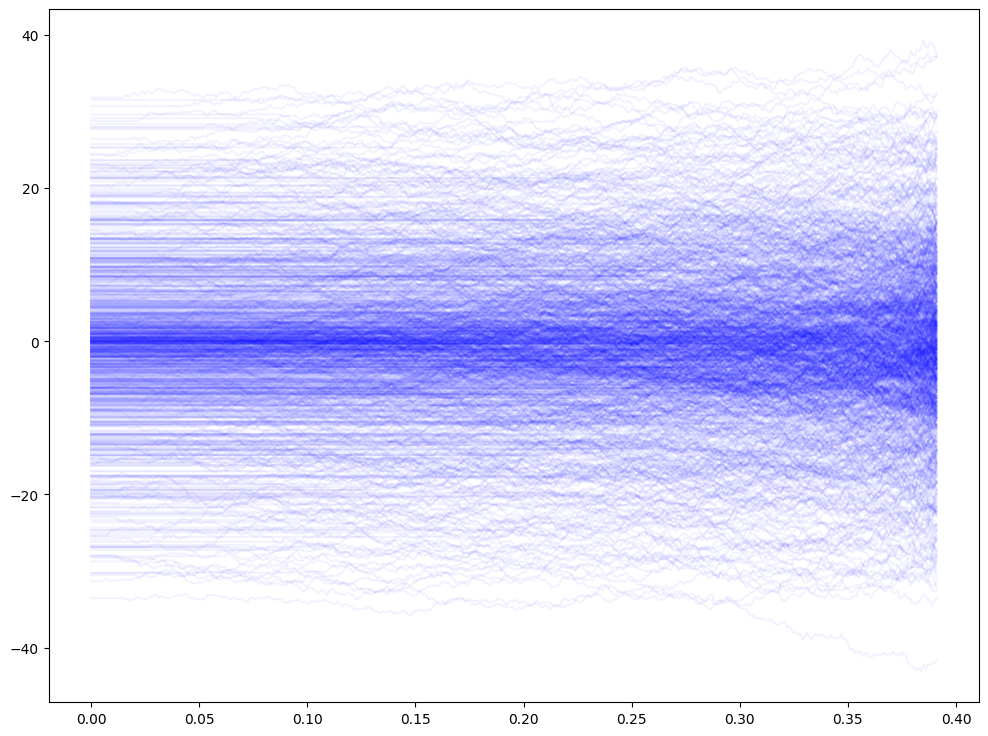

In [17]:
plt.figure(figsize=(12, 9))
for i in tqdm(range(len(propagator.z_coord_array))):
    plt.plot(propagator.z_grid, propagator.V_x_array_z_respect[i], alpha=0.05, color='blue')

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2413.71it/s]


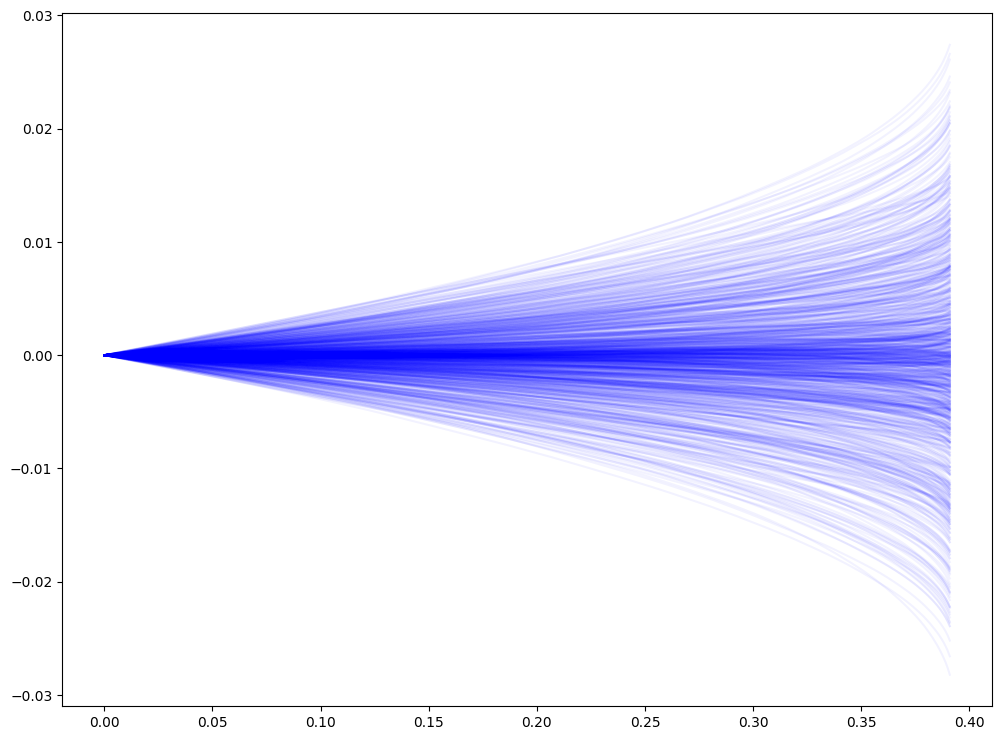

In [18]:
plt.figure(figsize=(12, 9))
for i in tqdm(range(len(propagator.z_coord_array))):
    plt.plot(propagator.z_grid, propagator.x_coord_array_z_respect[i], alpha=0.05, color='blue')

(0.0, 1.1)

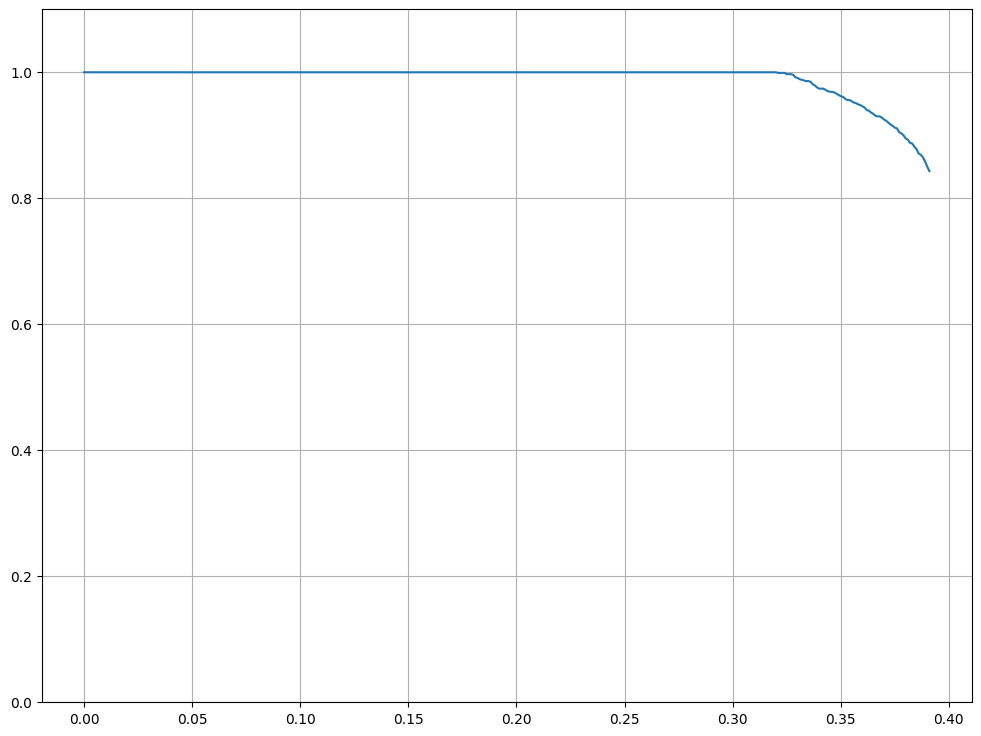

In [19]:
plt.figure(figsize=(12, 9))
plt.grid(True)
plt.plot(propagator.z_grid, propagator.exiting_ratio_z_respect)
plt.ylim(0, 1.1)

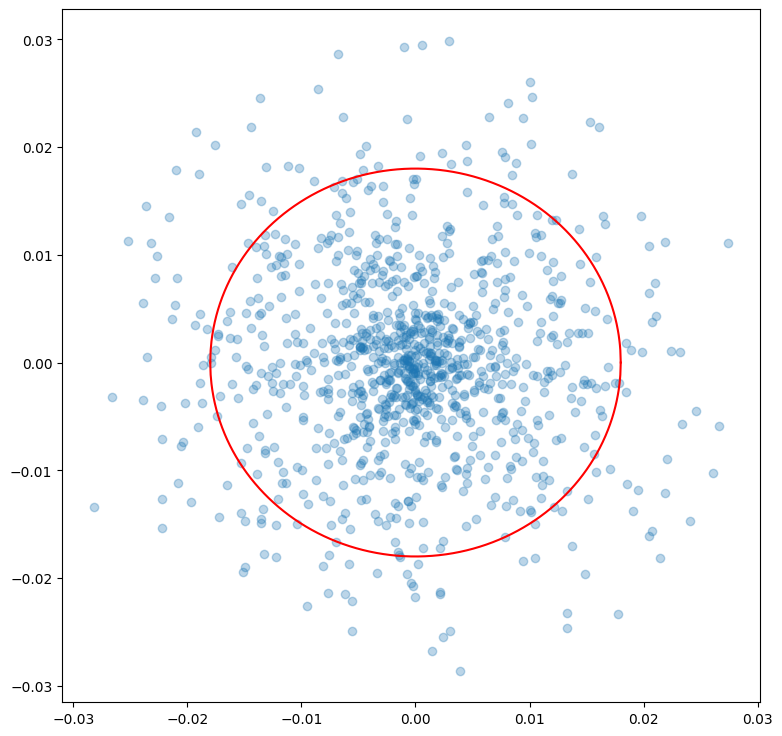

In [20]:
plt.figure(figsize=(9, 9))
_x = np.linspace(-slower_radius, slower_radius, 1000)
plt.scatter(propagator.x_coord_array_z_respect[:, -1], propagator.y_coord_array_z_respect[:, -1], alpha=0.3)
plt.plot(_x, np.sqrt(slower_radius**2 - _x**2), color='r')
plt.plot(_x, -np.sqrt(slower_radius**2 - _x**2), color='r')

In [21]:
propagator.count_std_transverse_velocities()

In [22]:
propagator.shifted_time_grid.shape

(8961,)

In [23]:
propagator.shifted_V_x_std.shape

(8961,)

In [24]:
len(propagator.shifted_V_x_array)

1000

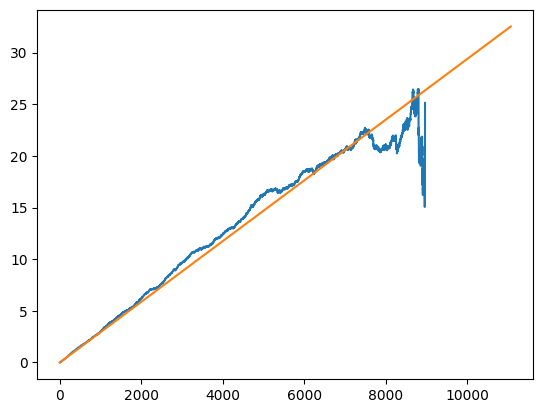

In [25]:
plt.plot(propagator.shifted_time_grid/delta_t, propagator.shifted_V_x_std**2)
t = np.linspace(0, 0.001, 100)
v_tr = 0.3*V_rec**2*t/delta_t
plt.plot(t/delta_t, v_tr)

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1250.97it/s]


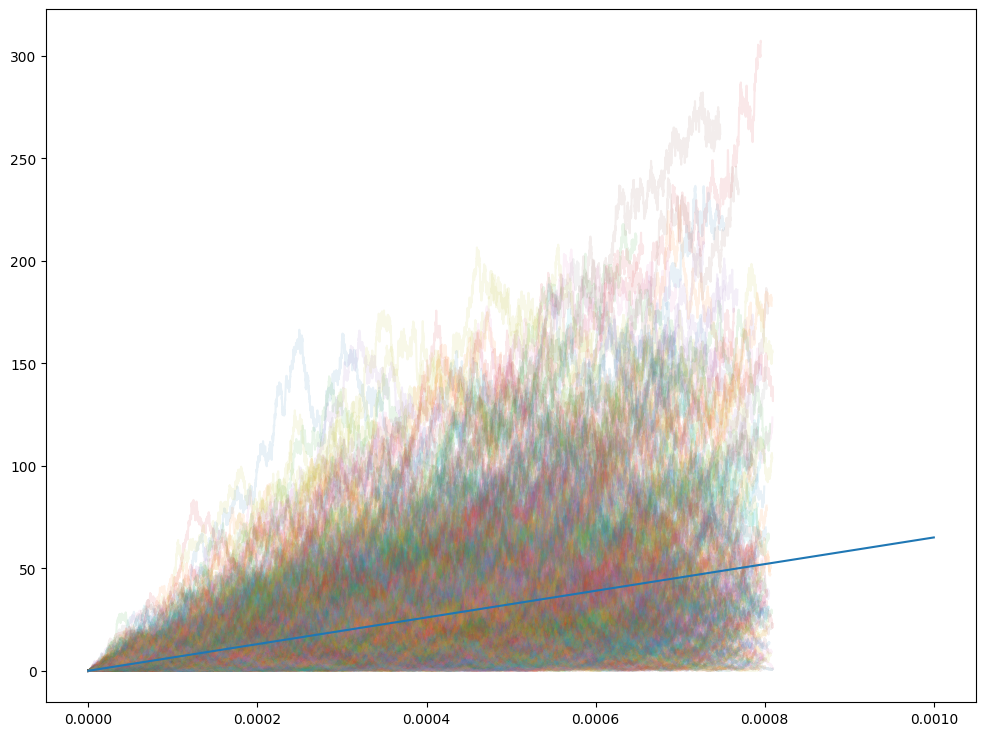

In [26]:
plt.figure(figsize=(12, 9))
for i in tqdm(range(len(propagator.shifted_time_array))):
    plt.plot(propagator.shifted_time_array[i], propagator.shifted_V_x_array[i]**2 + propagator.shifted_V_y_array[i]**2, alpha=0.1)
t = np.linspace(0, 0.001, 100)
v_tr = 0.6*V_rec**2*t/delta_t
plt.plot(t, v_tr)

(array([  1.,   4.,   6.,  11.,   7.,   9.,  21.,  13.,  25.,  33.,  28.,
         49.,  67.,  71., 116., 156.,  92.,  59.,  39.,  47.,  37.,  25.,
         22.,  14.,  14.,  14.,   7.,   3.,   7.,   3.]),
 array([-33.55672952, -31.37785461, -29.19897969, -27.02010477,
        -24.84122985, -22.66235494, -20.48348002, -18.3046051 ,
        -16.12573019, -13.94685527, -11.76798035,  -9.58910543,
         -7.41023052,  -5.2313556 ,  -3.05248068,  -0.87360576,
          1.30526915,   3.48414407,   5.66301899,   7.84189391,
         10.02076882,  12.19964374,  14.37851866,  16.55739358,
         18.73626849,  20.91514341,  23.09401833,  25.27289325,
         27.45176816,  29.63064308,  31.809518  ]),
 <BarContainer object of 30 artists>)

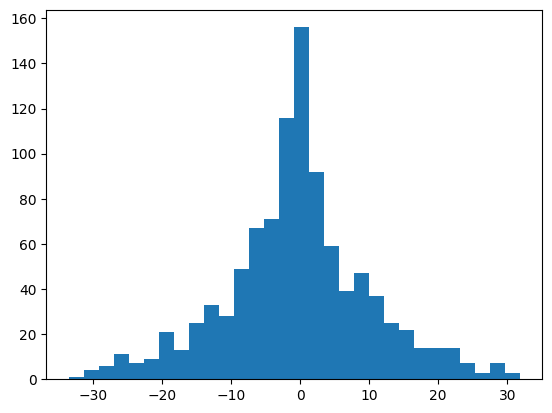

In [27]:
plt.hist(propagator.V_0_x_sample, bins=30)

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1501.57it/s]


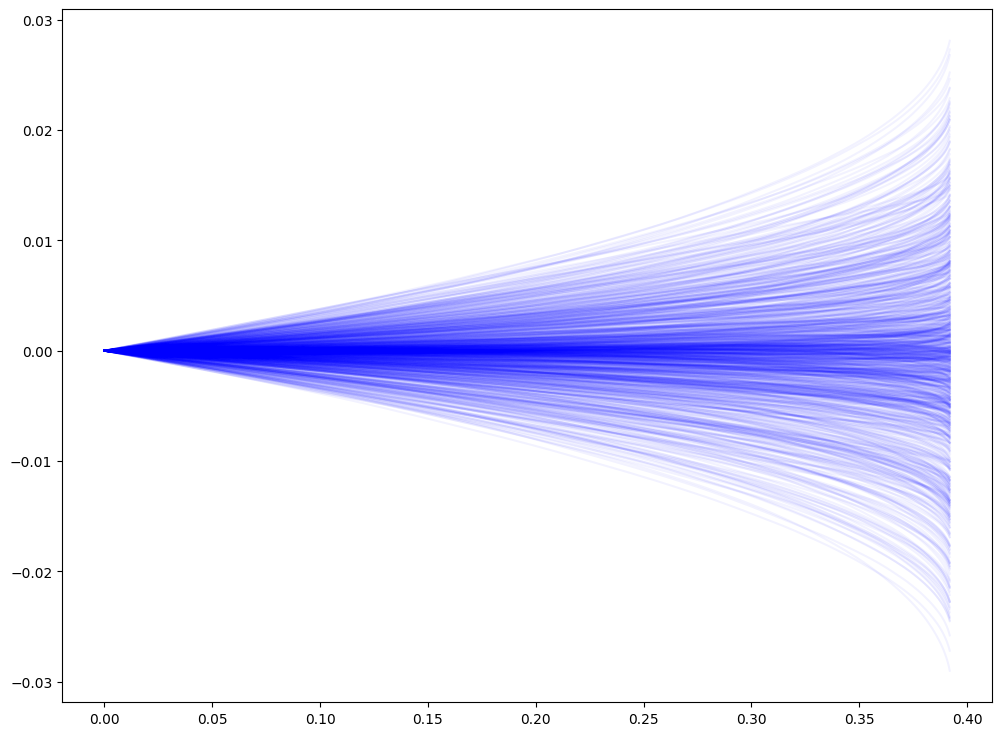

In [28]:
plt.figure(figsize=(12, 9))
for i in tqdm(range(len(propagator.z_coord_array))):
    plt.plot(propagator.z_coord_array[i], propagator.x_coord_array[i], alpha=0.05, color='blue')
# plt.ylim(-10, 10)

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1554.02it/s]


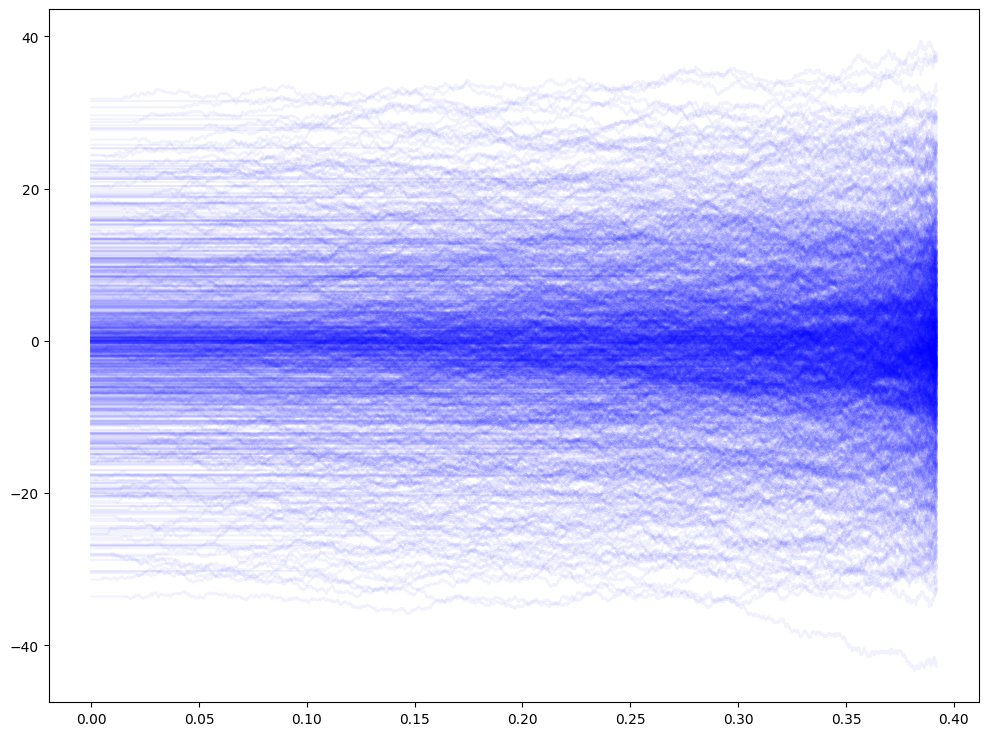

In [29]:
plt.figure(figsize=(12, 9))
for i in tqdm(range(len(propagator.z_coord_array))):
    plt.plot(propagator.z_coord_array[i], propagator.V_x_array[i], alpha=0.05, color='blue')

In [30]:
one_p_p = One_Particle_Propagator(500, 0, 0)
one_p_p.propagate()

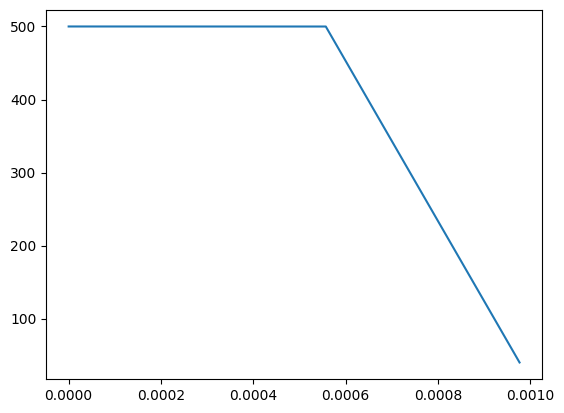

In [31]:
plt.plot(one_p_p.time_grid, one_p_p.V_z)


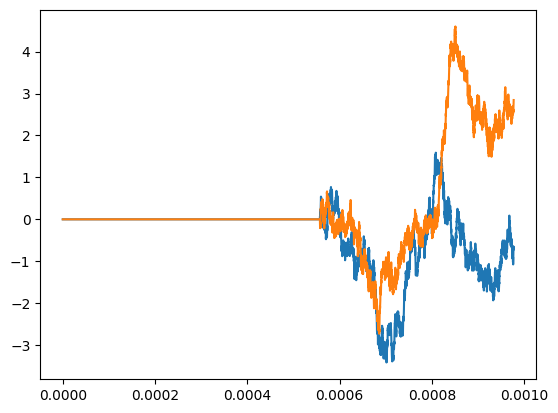

In [32]:
plt.plot(one_p_p.time_grid, one_p_p.V_x)
plt.plot(one_p_p.time_grid, one_p_p.V_y)

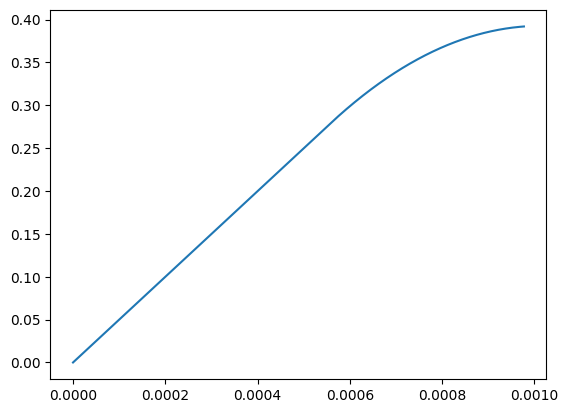

In [33]:
plt.plot(one_p_p.time_grid, one_p_p.z_coord)

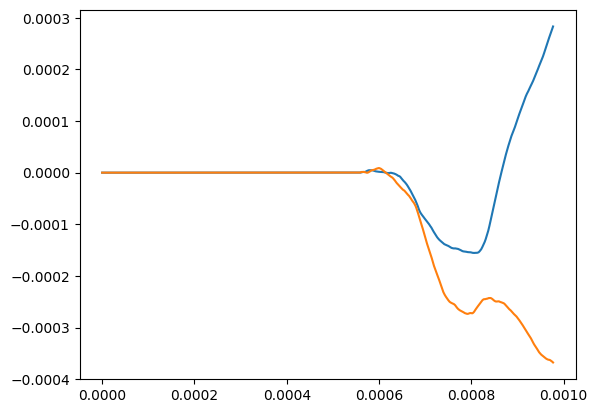

In [34]:
plt.plot(one_p_p.time_grid, one_p_p.y_coord)
plt.plot(one_p_p.time_grid, one_p_p.x_coord)

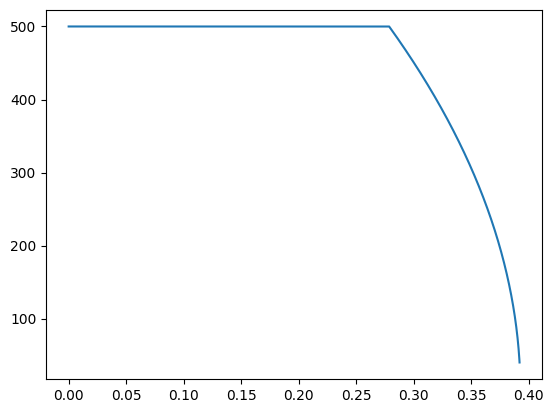

In [35]:
plt.plot(one_p_p.z_coord, one_p_p.V_z)